MoviePy - Building file boids_simulation_low.gif with imageio.


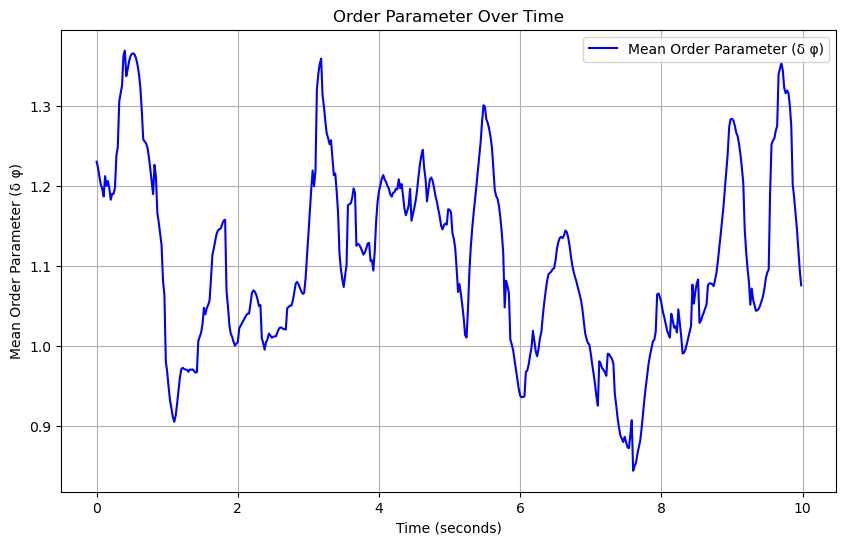

: 

In [ ]:
import pygame
import random
import math
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip  

pygame.init()

WIDTH, HEIGHT = 800, 600
BOID_COUNT = 50
BOID_RADIUS = 5
BOID_SPEED = 2
NEIGHBOR_RADIUS = 50 #radius where boids detect each other
SEPARATION_RADIUS = 30 #minimum radius apart
COUPLING_STRENGTH = 0.01  # Kuramoto coupling strength
FPS = 50

BLACK = (0, 0, 0)

# helping function to map one range to another (for coloring purposes)
def map_value(value, left_min, left_max, right_min, right_max):
    left_span = left_max - left_min
    right_span = right_max - right_min
    value_scaled = (value - left_min) / left_span
    return right_min + (value_scaled * right_span)

# coloring helper
def hsv_to_rgb(h, s, v):
    return tuple(int(c * 255) for c in pygame.Color(0).hsva_to_rgb(h, s, v))

# boid class
class Boid:
    def __init__(self, x, y):
        self.position = pygame.Vector2(x, y)
        self.velocity = pygame.Vector2(random.uniform(-1, 1), random.uniform(-1, 1)).normalize() * BOID_SPEED
        self.phase = math.atan2(self.velocity.y, self.velocity.x)  # initial heading as phase
        self.natural_frequency = random.uniform(-0.1, 0.1)  # random natural frequency

    def move(self):
        self.position += self.velocity
        # wrap around screen edges
        if self.position.x > WIDTH:
            self.position.x = 0
        elif self.position.x < 0:
            self.position.x = WIDTH
        if self.position.y > HEIGHT:
            self.position.y = 0
        elif self.position.y < 0:
            self.position.y = HEIGHT

    def draw(self, screen):
        # map phase to hue (color)
        hue = map_value(self.phase, -math.pi, math.pi, 0, 360)
        color = pygame.Color(0)
        color.hsva = (hue, 100, 100)  # full saturation and brightness
        pygame.draw.circle(screen, color, (int(self.position.x), int(self.position.y)), BOID_RADIUS)


# distance
def distance(vec1, vec2):
    return math.sqrt((vec1.x - vec2.x) ** 2 + (vec1.y - vec2.y) ** 2)

# phase based funtion, f
def phase_function(phase_diff):
    if 0 < phase_diff < math.pi:
        return (0.5 * phase_diff - 0.5 * math.pi) ** 2
    elif -math.pi < phase_diff <= 0:
        return (0.5 * phase_diff + 0.5 * math.pi) ** 2
    else:
        return 0  # Outside defined range or y > 2.4674

# gaussian function, g
def gaussian(distance, sigma=25):  # Adjust sigma for interaction range
    return math.exp(-distance**2 / (2 * sigma**2))


# boid rules
def apply_kuramoto(boid, boids, coupling_strength):
    phase_coupling = 0
    nearby_boids = 0

    for other in boids:
        if other == boid:
            continue
        if distance(boid.position, other.position) < NEIGHBOR_RADIUS:
            nearby_boids += 1
            phase_coupling += math.sin(other.phase - boid.phase)

    if nearby_boids > 0:
        # update phase using natural frequency and coupling
        boid.phase += boid.natural_frequency + (coupling_strength / nearby_boids) * phase_coupling
        # keep phase within [-pi, pi] 
        boid.phase = (boid.phase + math.pi) % (2 * math.pi) - math.pi

    # Update velocity to align with new phase
    boid.velocity = pygame.Vector2(math.cos(boid.phase), math.sin(boid.phase)) * BOID_SPEED


def apply_rules(boid, boids):
    separation_force = pygame.Vector2(0, 0)
    alignment_force = pygame.Vector2(0, 0)
    cohesion_force = pygame.Vector2(0, 0)
    nearby_boids = 0

    # loop through all boids to calculate separation, alignment, and cohesion
    for other in boids:
        if other == boid:
            continue
        dist = distance(boid.position, other.position)
        if dist < NEIGHBOR_RADIUS:
            nearby_boids += 1
            alignment_force += other.velocity
            cohesion_force += other.position
            if dist < SEPARATION_RADIUS:
                separation_force += boid.position - other.position

    if nearby_boids > 0:
        # normalize/average forces
        if alignment_force.length() > 0:
            alignment_force = alignment_force.normalize() * BOID_SPEED
        else:
            alignment_force = pygame.Vector2(0, 0)
        cohesion_force = ((cohesion_force / nearby_boids) - boid.position).normalize() * BOID_SPEED
        if separation_force.length() > 0:  # Avoid zero-length vector normalization
            separation_force = separation_force.normalize() * BOID_SPEED


    # combine forces with weights for flocking
    combined_velocity = boid.velocity + separation_force * 1.5 + alignment_force * 1.0 + cohesion_force * 1.0

    # add the phase and spatial influence
    phase_velocity = pygame.Vector2(0, 0)
    for other in boids:
        if other == boid:
            continue
        
        phase_diff = abs((other.phase - boid.phase + math.pi) % (2 * math.pi) - math.pi)

        # calculate spatial distance
        dist = distance(boid.position, other.position)
        
        # compute contributions
        f_val = phase_function(phase_diff)
        g_val = gaussian(dist)
        direction = pygame.Vector2(math.cos(boid.phase), math.sin(boid.phase))
        contribution = direction * f_val * g_val

        
        phase_velocity += contribution

    # N]normalize the resulting phase velocity and scale to BOID_SPEED
    if phase_velocity.length() > 0:
        phase_velocity = phase_velocity.normalize() * BOID_SPEED

    # combine flocking velocity with phase-based velocity
    # random_noise = pygame.Vector2(random.uniform(-0.5, 0.5), random.uniform(-0.5, 0.5))
    boid.velocity = combined_velocity + phase_velocity 
    boid.velocity = boid.velocity.normalize() * BOID_SPEED  # Ensure consistent speed

    # apply Kuramoto coupling for phase synchronization
    apply_kuramoto(boid, boids, COUPLING_STRENGTH)

def calculate_order_parameter(boids):
    delta_phi = []
    for i, boid_i in enumerate(boids):
        numerator = 0
        denominator = 0
        for j, boid_j in enumerate(boids):
            if i == j:
                continue
            phase_diff = abs((boid_i.phase - boid_j.phase + math.pi) % (2 * math.pi) - math.pi)
            spatial_dist = distance(boid_i.position, boid_j.position)
            f_val = phase_function(phase_diff)
            g_val = gaussian(spatial_dist)
            numerator += f_val * phase_diff * g_val
            denominator += f_val * g_val
        if denominator > 0:
            delta_phi_i = numerator / denominator
        else:
            delta_phi_i = 0  # Handle cases with no neighbors
        delta_phi.append(delta_phi_i)
    return delta_phi


# MAIN FUNCTION
def main():
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Boids Simulation with Kuramoto Coupling and Phase Coloring")
    clock = pygame.time.Clock()

    # initialize boids
    boids = [Boid(random.randint(0, WIDTH), random.randint(0, HEIGHT)) for _ in range(BOID_COUNT)]

    # variables to store data for plotting
    time_steps = []
    mean_delta_phi_values = []

    running = True
    frame_count = 0
    total_simulation_time = 10  # sec

    frames = []

    while running:
        screen.fill(BLACK)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Update Boids
        for boid in boids:
            apply_rules(boid, boids)
            boid.move()
            boid.draw(screen)

        frame_data = pygame.surfarray.array3d(screen)
        frame_data = frame_data.transpose(1, 0, 2)  # standard image format
        frames.append(frame_data)

        # calculate the mean order parameter
        delta_phi = calculate_order_parameter(boids)
        mean_delta_phi = sum(delta_phi) / len(delta_phi) if delta_phi else 0
        time_steps.append(frame_count / FPS)  # Time in seconds
        mean_delta_phi_values.append(mean_delta_phi)

        pygame.display.flip()
        clock.tick(FPS)
        frame_count += 1

        # stop simulation after 20 seconds
        if frame_count >= total_simulation_time * FPS:
            running = False

    pygame.quit()

    gif_path = "boids_simulation_low.gif"
    clip = ImageSequenceClip(frames, fps=FPS)
    clip.write_gif(gif_path, fps=FPS)

    # plot results after simulation
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, mean_delta_phi_values, label='Mean Order Parameter (\u03B4 \u03C6)', color='blue')
    plt.title("Order Parameter Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Mean Order Parameter (\u03B4 \u03C6)")
    plt.legend()
    plt.grid()
    plt.show()




# run Simulation
if __name__ == "__main__":
    main()
